# Loads an ensemble of models, applies it to all of the szr data for a patient, and outputs the classifier results to disk

In [1]:
# Libraries
import numpy as np
import scipy.io as sio
import os
import pickle
# import re
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import preprocessing
# from scipy import stats
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import svm, linear_model
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import imp 
imp.reload(dg) 

<module 'dgFuncs' from '/Users/davidgroppe/PycharmProjects/DG_LIBRARY/dgFuncs.py'>

In [3]:
# Function for extracting channel names from filename
def chan_labels_from_fname(in_file):
    just_fname=in_file.split('/')[-1]
    jf_splt=just_fname.split('_')
    chan_label=jf_splt[1]+'-'+jf_splt[2]
    return chan_label

In [49]:
# Get list of electrodes for the subject
def sub_soz_elec_names(sub,ftr_root):
    soz_elec_names=list()
    szr_fname_dict=dict()
    non_elec_names=list()
    
    ftr_path=os.path.join(ftr_root,str(sub))
    for f in os.listdir(ftr_path):
            if f.endswith('non.mat'):
                non_elec_names.append(chan_labels_from_fname(f))
            elif f.endswith('.mat') and f.startswith(str(sub)+'_'):
                temp_label=chan_labels_from_fname(f)
                if temp_label in soz_elec_names:
                    szr_fname_dict[soz_elec_names[-1]].append(f)
                else:
                    soz_elec_names.append(temp_label)
                    szr_fname_dict[temp_label]=[f]
                    
    soz_elec_names=np.unique(soz_elec_names)
    non_elec_names=np.unique(non_elec_names)
    print('%d total # of electrodes for this sub' % len(soz_elec_names))
        
    return soz_elec_names, szr_fname_dict

In [51]:
# Load saved model
model_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/MODELS/genLogregSe_3/classify_models_srch.pkl'
models=pickle.load(open(model_fname,'rb'))
n_models=len(models)
print('# of models= %d' % n_models)
print(type(models[0]))

['HL1-HL2' 'HL2-HL3' 'HL3-HL4' 'HL4-HL5' 'HL5-HL6' 'HL6-HL7' 'HL7-HL8'
 'HL8-HL9' 'HL9-HL10']
['1096_HL9_HL10_szr2.mat']
HL1
HL2


In [80]:
sub=1096
model_name='genLogregSe'
yhat_dir=os.path.join('/Users/davidgroppe/PycharmProjects/SZR_ANT/MODELS/',model_name+'_yhat')
ftr_root='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/'
# Get list of electrodes
soz_elec_names, szr_fname_dict=sub_soz_elec_names(sub,ftr_root)
ftr_path=os.path.join(ftr_root,str(sub))
for elec in soz_elec_names[:1]:
    # load non szr file
    uni_chans=elec.split('-')
    nonszr_fname=str(sub)+'_'+uni_chans[0]+'_'+uni_chans[1]+'_non.mat'
    #print('Loading %s' % nonszr_fname)
    temp_ftrs=sio.loadmat(os.path.join(ftr_path,nonszr_fname))
    # Z-score features
    temp_mns, temp_sds=dg.trimmed_normalize(temp_ftrs['nonszr_se_ftrs'],0,zero_nans=False,verbose=False)
    
    # get list of szr files
    for szr_f in szr_fname_dict[elec]:
        #load file
#         print('Loading %s' % szr_f)
        temp_ftrs=sio.loadmat(os.path.join(ftr_path,szr_f))
        raw_ftrs=temp_ftrs['se_ftrs']
        # Z-score based on non-ictal means, SDs
        dg.applyNormalize(raw_ftrs,temp_mns,temp_sds)
        
        # Apply classifiers
        for model_ct in range(n_models):
            tmp_yhat_va = models[model_ct].predict_proba(raw_ftrs.T)[:,1]
            if model_ct==0:
                yhat=np.zeros(tmp_yhat_va.shape)
            yhat+=tmp_yhat_va/n_models
        out_fname=str(sub)+'_'+uni_chans[0]+'_'+uni_chans[1]+'_phat_'+szr_f.split('_')[-1]
        print('Saving file as %s' % out_fname)
        sio.savemat(os.path.join(yhat_dir,out_fname), mdict={'yhat': yhat,
                                                             'model_name': model_name,
                                                             'ftr_fname': szr_f})
#         sio.savemat(os.path.join(yhat_dir,out_fname), mdict={'yhat': yhat,
#                                                             'yhat_sec': temp_ftrs['se_time_sec'],
#                                                             'szr': temp_ftrs['se_szr_class']})
    #        save predictions to disk
print('done')

9 total # of electrodes for this sub
tmp_yhat_va.shape (1245,), ftrs_va.shape (30, 1245) 
tmp_yhat_va.shape (1245,), ftrs_va.shape (30, 1245) 
tmp_yhat_va.shape (1245,), ftrs_va.shape (30, 1245) 
tmp_yhat_va.shape (1245,), ftrs_va.shape (30, 1245) 
tmp_yhat_va.shape (1245,), ftrs_va.shape (30, 1245) 
Saving file as 1096_HL1_HL2_phat_szr0.mat
tmp_yhat_va.shape (1208,), ftrs_va.shape (30, 1208) 
tmp_yhat_va.shape (1208,), ftrs_va.shape (30, 1208) 
tmp_yhat_va.shape (1208,), ftrs_va.shape (30, 1208) 
tmp_yhat_va.shape (1208,), ftrs_va.shape (30, 1208) 
tmp_yhat_va.shape (1208,), ftrs_va.shape (30, 1208) 
Saving file as 1096_HL1_HL2_phat_szr2.mat
tmp_yhat_va.shape (1234,), ftrs_va.shape (30, 1234) 
tmp_yhat_va.shape (1234,), ftrs_va.shape (30, 1234) 
tmp_yhat_va.shape (1234,), ftrs_va.shape (30, 1234) 
tmp_yhat_va.shape (1234,), ftrs_va.shape (30, 1234) 
tmp_yhat_va.shape (1234,), ftrs_va.shape (30, 1234) 
Saving file as 1096_HL1_HL2_phat_szr6.mat
done


In [74]:
print(temp_ftrs.keys())
print(temp_ftrs['se_time_sec'].shape)
print(temp_ftrs['se_ftrs'].shape)
print(tmp_yhat_va.shape)
yhat.shape

dict_keys(['sgram_S', '__globals__', '__version__', 'targ_raw_ieeg', 'sgram_t', 'szr_fname', 'se_time_sec', 'se_ftrs', 'sgram_f', 'targ_raw_ieeg_sec', 'se_szr_class', '__header__', 'ftr_labels'])
(1, 1234)
(30, 1234)
(1234,)


(1234,)

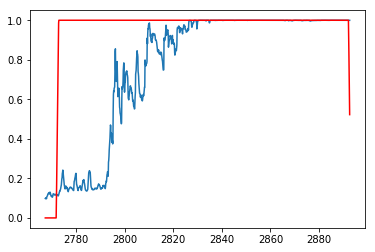

In [77]:
plt.figure(1)
plt.plot(np.squeeze(temp_ftrs['se_time_sec']),yhat)
plt.plot(np.squeeze(temp_ftrs['se_time_sec']),np.squeeze(temp_ftrs['se_szr_class']),'r-')